# Learning XOR with an Optical network with Kerr-nonlinearities

### Self- vs Cross-Kerr nonlinearity (quadrature basis)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# XOR Dataset
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
targets = np.array([0, 1, 1, 0])

# Network's parameters
np.random.seed(220) # seed
N = 10  # Number of nodes
N_out = 1  # Number of output nodes
kappa = np.ones(N)  # Decay rates
g = 0.3  # Nonlinearity
J = 2/N * np.random.randn(N, N)  # Connectivity matrix
J = (J + J.T) / 2
beta = 1e-2  # Perturbation magnitude

# Nonlinearity's connectivity
# 1) Only Self-Kerr:
# G = np.eye(N)
# 2) Self-Kerr + next neighbors Cross-Kerr:
G = np.zeros((N, N), dtype=int)
for i in range(N):
    G[i, (i-1) % N] = 1  # Connect to previous node
    G[i, (i+1) % N] = 1  # Connect to next node

# Initialize state
y0 = np.random.randn(2 * N) 

# System dynamics
def system(t, y, args):
    kappa, g, J, x_in, p_in = args
    N = len(kappa)
    x = y[:N]
    p = y[N:]
    dxdt = -0.5 * kappa * x + np.dot(J,p) + 0.5 * g * p * np.dot(G, (x**2 + p**2)) - np.sqrt(kappa) * x_in
    dpdt = -0.5 * kappa * p - np.dot(J,x) - 0.5 * g * x * np.dot(G, (x**2 + p**2)) - np.sqrt(kappa) * p_in
    return np.concatenate([dxdt, dpdt])

x_in = np.zeros(N)
p_in = np.zeros(N)

# Quasy-symmetry:
sigma_z = np.block([
    [np.eye(N), np.zeros((N,N))],
    [np.zeros((N,N)), -np.eye(N)]
])

In [ ]:
# Runge Kutta ode solver
def rk4_step(f, y, t, dt, args):
    """Performs a single step of the 4th-order Runge-Kutta method for solving ODEs."""
    k1 = f(t, y, args)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1 * dt, args)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2 * dt, args)
    k4 = f(t + dt, y + k3 * dt, args)
    
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_rk4(f, y0, t_span, dt, args):
    """Solves an ODE using RK4 over a time range."""
    t_values = np.arange(t_span[0], t_span[1] + dt, dt)
    y_values = []
    y_values.append(y0)
    
    for i in range(1, len(t_values)):
        y_values.append(rk4_step(f, y_values[i-1], t_values[i-1], dt, args))
    
    return t_values, np.array(y_values)

tmax = 60
dt = 0.1

In [11]:
# Generate a list of random seeds
num_configs = 10  # Number of random configurations per N
random_seeds = [np.random.randint(0, 100000) for _ in range(num_configs)]

# Training loop
num_epochs = 1000

learning_rate = 0.001
histories = []


for seed in random_seeds:
    np.random.seed(seed) 
    # New random connectivity matrix
    J = 2/N * np.random.randn(N, N)  
    J = (J + J.T) / 2

    # Initialize state
    y0 = np.random.randn(2 * N) 

    loss_history = []

    for epoch in range(num_epochs):  # Number of epochs
        epoch_loss = 0
        for input_vec, target in zip(inputs, targets):
            # Set inputs
            x_in = np.zeros(N)
            p_in = np.zeros(N)
            x_in[:2] = input_vec 

            # Inference Phase:
            # Compute steady state
            _ , steady_state = solve_rk4(system, y0, (0,tmax), dt, args=(kappa, g, J, x_in, p_in))
            solution_free = steady_state[-1]
            x_free = solution_free[:N]
            p_free = solution_free[N:]
            y0 = solution_free # update initial condition

            # Compute loss for the current sample
            y = 10 * x_free[4] # we consider the output to be x_out[4] = x_free[4] (note that kappa=1 and x_in[4]=0)
            loss = (y - target)**2    
            epoch_loss += loss
            
            # Feedback Phase:
            # Inject error signal (computed using U' = sigma_z, corresponding to U = sigma_x in the a(t)-basis )
            x_in[4] += beta * 2 * 10 * (y - target) 

            # Compute steady state
            _ , steady_state = solve_rk4(system, y0, (0,tmax/2), dt, args=(kappa, g, J, x_in, p_in))
            solution_perturbed = steady_state[-1]

            y0 = solution_perturbed # update initial condition

            # Update weights
            for j in range(N):
                for l in range(N):
                    dFdJ_jl = np.zeros(2 * N)
                    dFdJ_jl[j] = p_free[l]
                    dFdJ_jl[l] = p_free[j]
                    dFdJ_jl[j+N] = - x_free[l] 
                    dFdJ_jl[l+N] = - x_free[j] 
                    if j == l:
                        dFdJ_jl[j] /= 2
                        dFdJ_jl[j+N] /= 2
                    # Weight update using U' = sigma_z (corresponding to U = sigma_x in the a(t)-basis )
                    dJ_jl = (0.5 * learning_rate) * dFdJ_jl.T @ sigma_z @ (solution_perturbed - solution_free)/beta 
                    J[j,l] += dJ_jl
                    J[l,j] += dJ_jl 


        # Average loss for the epoch
        epoch_loss = epoch_loss / len(inputs)
        loss_history.append(epoch_loss)

    histories.append(loss_history.copy())

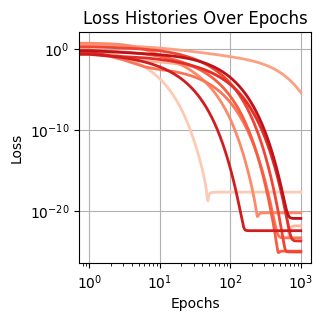

In [13]:
# Plot the loss histories
colors = plt.cm.Reds(np.linspace(0.2, 0.8, len(histories)) )

plt.figure(figsize=(3, 3))  

for i, (history, color) in enumerate(zip(histories, colors)):
    plt.plot(history[:], label=f'Seed {random_seeds[i]}', color=color, linewidth=2)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Histories Over Epochs')
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e-0, 1e-10, 1e-20])
plt.grid()
plt.show()
